In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2


In [3]:
adata = sc.read_10x_mtx("../data/Ileum/", cache=True)
adata

... reading from cache file cache/..-data-Ileum-matrix.h5ad


AnnData object with n_obs × n_vars = 39671 × 33660
    var: 'gene_ids'

In [4]:
obs = pd.read_table("../data/Ileum/Effi_tsne_final.txt", header=[0, 1])
obs.columns = [i[0] for i in obs.columns]
obs.index = obs.NAME
adata = adata[obs.NAME, :]
adata.obs = obs
adata.obs

,NAME,X,Y,Primary Lineages,kmeans
NAME,,,,,
122_AAACCTGGTTCCCGAG,122_AAACCTGGTTCCCGAG,-17.523981,25.760201,IgA plasma cells,5
122_AAAGATGTCAGCTCTC,122_AAAGATGTCAGCTCTC,-4.299636,-1.107461,Tregs,2
122_AAAGCAACAAGAAGAG,122_AAAGCAACAAGAAGAG,18.438143,-1.855235,Mast cells,17
122_AAATGCCTCACCCGAG,122_AAATGCCTCACCCGAG,8.266746,4.860057,TRM,3
122_AACCATGCATCACCCT,122_AACCATGCATCACCCT,1.359606,36.710104,IgA plasma cells,10
...,...,...,...,...,...
209_TTTGTCAGTCTCTTAT,209_TTTGTCAGTCTCTTAT,11.309222,21.416638,TRM,1
209_TTTGTCAGTGTGGTTT,209_TTTGTCAGTGTGGTTT,23.971407,1.429820,Group3 ILC,13
209_TTTGTCATCAGTTAGC,209_TTTGTCATCAGTTAGC,8.514284,0.595697,TRM,3


In [5]:
adata.obsm['X_orig'] = adata.obs[['X', 'Y']]

In [6]:
adata.obs['batch'] = adata.obs.NAME.str[0:3]

In [7]:
sample_info = pd.crosstab(adata.obs['batch'], adata.obs['Primary Lineages'])
sample_info.style

Primary Lineages,ACKR1+ endothelial cells,B cells,CD36+ endothelial cells,Central Memory T cells,Cytotoxic T cells,DC1,DC2,DC2 CD206+,Fibroblasts,Glial Cells,Group1 ILC,Group3 ILC,Highly activated T cells,IgA plasma cells,IgG plasma cells,IgM plasma cells,Lymphatics,Macrophages,Mast cells,Naive T cells,Pericytes,Plasmablasts,Smooth muscle cells,T (gd),TFH-like T cells,TRM,Tregs
batch,,,,,,,,,,,,,,,,,,,,,,,,,,,
122,1,10,0,4,2,2,19,1,6,0,7,20,2,142,7,13,0,6,19,1,0,0,0,7,10,145,13
128,76,641,2,82,34,12,27,8,16,0,63,5,129,248,415,61,1,18,4,20,7,26,1,19,79,172,146
138,67,1618,2,956,191,13,5,7,6,0,38,19,74,90,299,17,7,14,8,35,15,20,5,24,56,66,178
158,6,133,15,16,73,10,78,41,13,0,26,47,14,671,18,40,2,85,9,158,2,19,7,32,212,1305,100
181,60,2690,11,33,296,13,63,11,9,1,132,26,216,765,287,40,4,47,25,1566,3,71,2,54,1042,854,461
187,99,43,4,5,6,28,34,0,12,2,14,11,61,143,203,36,0,24,3,20,6,10,3,6,12,54,53
190,12,766,43,2,77,38,58,32,56,1,29,202,17,399,37,46,9,68,3,1073,8,10,17,49,229,1217,261
193,36,1462,41,11,51,14,162,83,18,4,343,89,52,1030,121,227,5,139,13,543,26,26,2,20,853,3014,448
196,10,239,19,8,39,10,77,29,49,0,36,40,29,567,137,79,2,115,4,15,5,33,17,9,171,515,223


In [8]:
sample_info.sum(axis=1)

batch
122     437
128    2312
138    3830
158    3132
181    8782
187     892
190    4759
193    8833
196    2477
209    4109
dtype: int64

In [9]:
train_data = adata[adata.obs.batch != '193']
test_data = adata[adata.obs.batch == '193']

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Primary Lineages' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


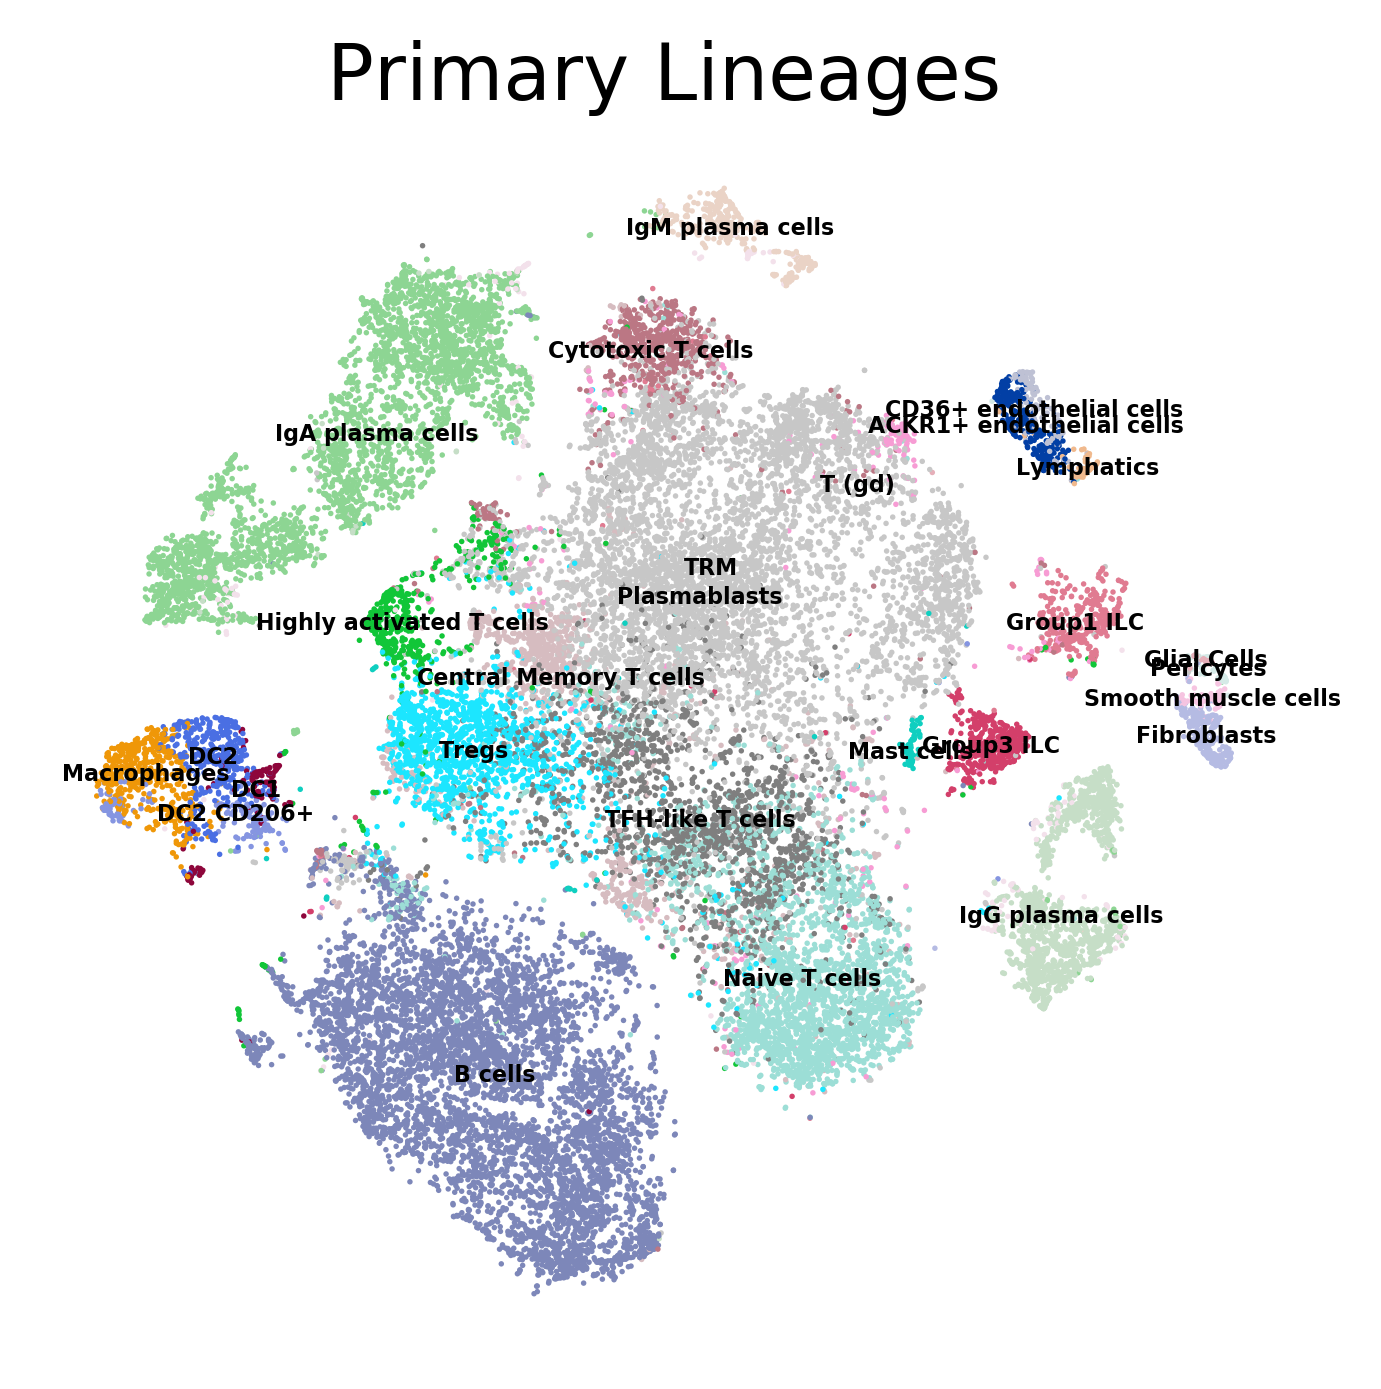

In [10]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.embedding(train_data, 'X_orig', color="Primary Lineages", frameon=False, ncols=2, legend_loc="on data", legend_fontsize=4)

Trying to set attribute `.obs` of view, copying.
... storing 'Primary Lineages' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


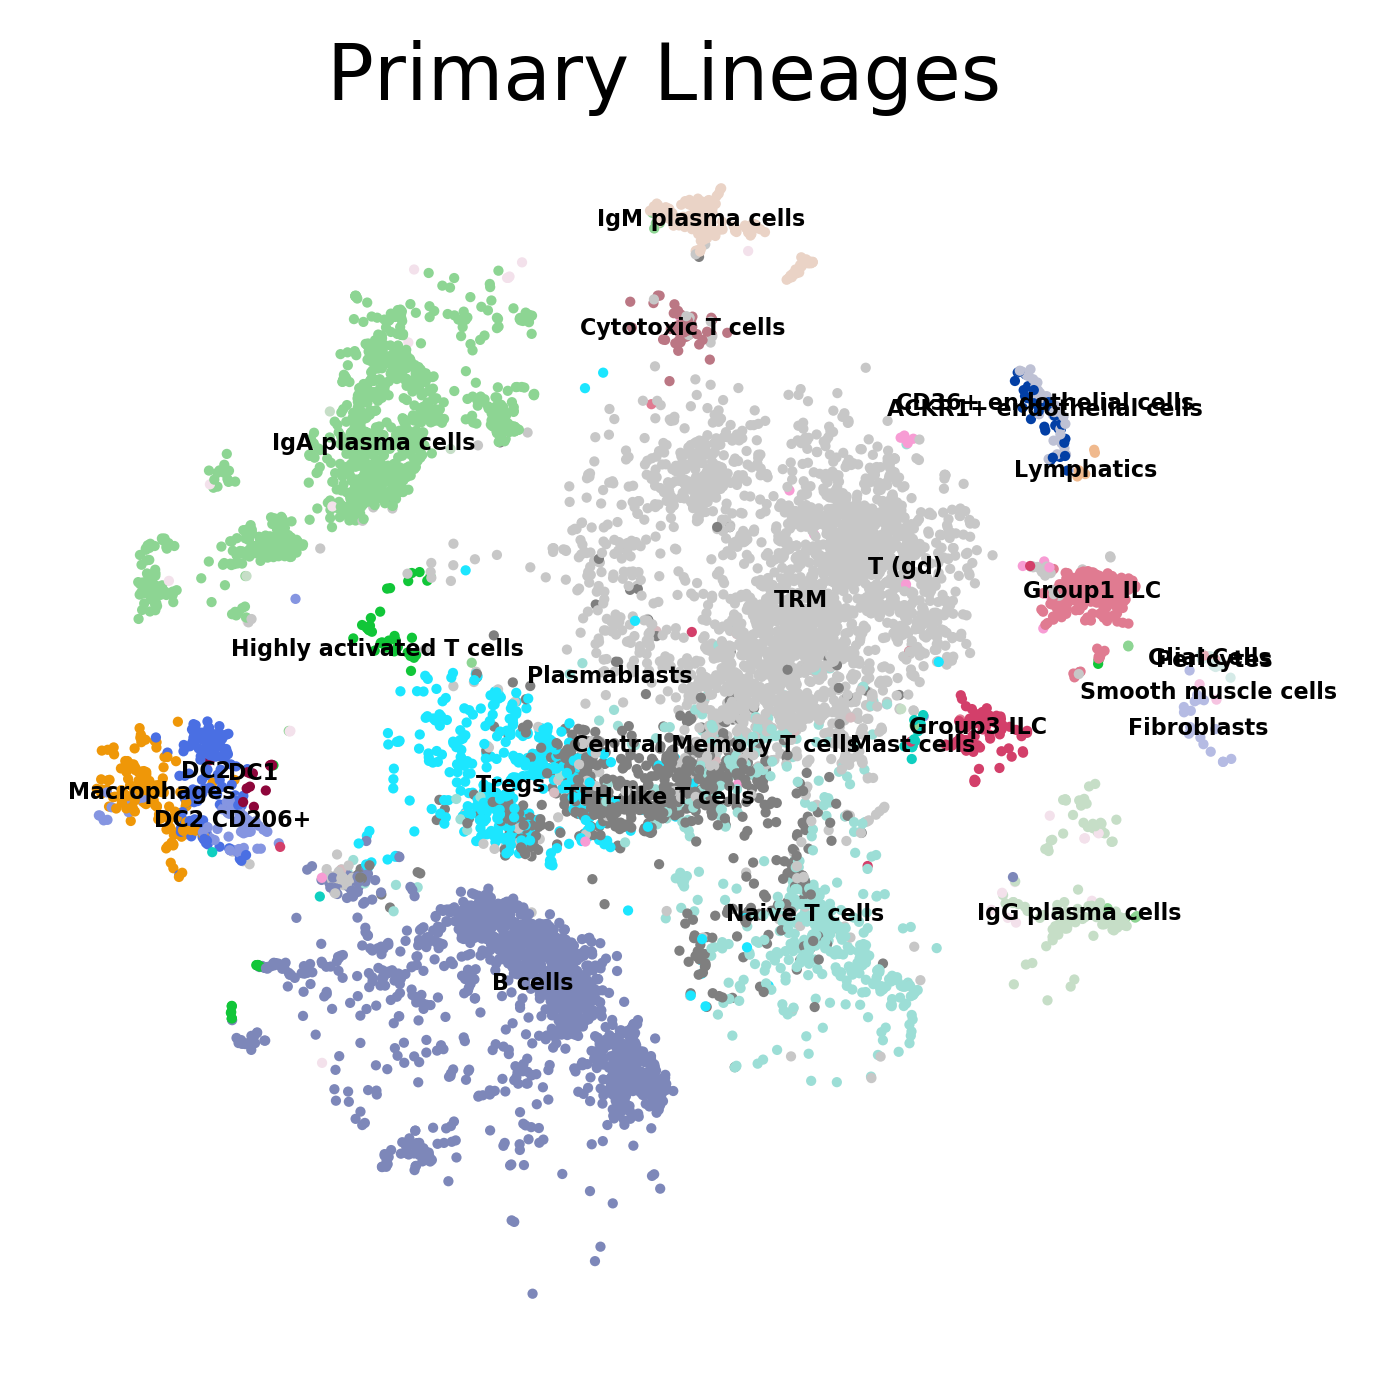

In [11]:
sc.pl.embedding(test_data, 'X_orig', color="Primary Lineages", frameon=False, ncols=2, legend_loc="on data", legend_fontsize=4)

In [12]:
def preproc(adata):
    adata.raw = adata
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    
preproc(train_data)
preproc(test_data)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [13]:
from pyuoi.decomposition.CUR import CUR

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: Fut

In [14]:
cur = CUR(max_k=5000, random_state=0)
train_data.obsm['X_cur'] = cur.fit_transform(train_data.X)
test_data.obsm['X_cur'] = cur.transform(test_data.X)

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score

In [16]:
classifier = DecisionTreeClassifier(class_weight="balanced", max_depth=20)
classifier.fit(train_data.obsm['X_cur'], train_data.obs["Primary Lineages"])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
train_pred = classifier.predict(train_data.obsm['X_cur'])
test_pred = classifier.predict(test_data.obsm['X_cur'])

In [18]:
display(f1_score(y_true=train_data.obs["Primary Lineages"], y_pred=train_pred, average="macro"))
display(pd.DataFrame(confusion_matrix(y_true=train_data.obs["Primary Lineages"], y_pred=train_pred),
                     index=classifier.classes_, columns=classifier.classes_).style
       )

0.7722733696666453

,ACKR1+ endothelial cells,B cells,CD36+ endothelial cells,Central Memory T cells,Cytotoxic T cells,DC1,DC2,DC2 CD206+,Fibroblasts,Glial Cells,Group1 ILC,Group3 ILC,Highly activated T cells,IgA plasma cells,IgG plasma cells,IgM plasma cells,Lymphatics,Macrophages,Mast cells,Naive T cells,Pericytes,Plasmablasts,Smooth muscle cells,T (gd),TFH-like T cells,TRM,Tregs
ACKR1+ endothelial cells,313,0,0,0,0,0,2,0,0,0,0,0,11,0,0,0,0,0,0,0,0,10,0,0,0,0,1
B cells,0,5628,0,6,34,28,41,4,0,0,4,0,76,2,10,0,0,14,0,110,0,16,0,3,260,27,25
CD36+ endothelial cells,0,0,130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0
Central Memory T cells,0,1,1,633,32,0,2,0,0,0,3,9,27,0,1,0,0,1,0,43,0,16,0,42,218,40,37
Cytotoxic T cells,0,4,0,15,540,2,1,0,0,0,5,0,15,0,2,0,0,1,0,11,0,6,0,27,100,22,10
DC1,0,0,0,0,0,151,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2
DC2,0,1,0,0,0,0,387,0,0,0,0,0,10,0,0,0,0,13,0,0,0,0,0,4,17,0,2
DC2 CD206+,0,0,0,0,0,1,0,187,0,0,0,1,1,0,0,0,0,5,0,0,0,0,0,2,3,1,2
Fibroblasts,0,0,0,0,0,0,0,0,300,0,0,0,2,0,0,0,0,0,0,0,0,9,6,0,1,0,0
Glial Cells,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [19]:
display(f1_score(y_true=test_data.obs["Primary Lineages"], y_pred=test_pred, average="macro"))
display(pd.DataFrame(confusion_matrix(y_true=test_data.obs["Primary Lineages"], y_pred=test_pred),
                     index=classifier.classes_, columns=classifier.classes_).style
       )

0.4413714816332619

,ACKR1+ endothelial cells,B cells,CD36+ endothelial cells,Central Memory T cells,Cytotoxic T cells,DC1,DC2,DC2 CD206+,Fibroblasts,Glial Cells,Group1 ILC,Group3 ILC,Highly activated T cells,IgA plasma cells,IgG plasma cells,IgM plasma cells,Lymphatics,Macrophages,Mast cells,Naive T cells,Pericytes,Plasmablasts,Smooth muscle cells,T (gd),TFH-like T cells,TRM,Tregs
ACKR1+ endothelial cells,23,1,6,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,2,0
B cells,1,1315,0,1,1,7,27,4,0,0,1,0,8,12,50,0,0,7,2,16,0,4,0,0,2,3,1
CD36+ endothelial cells,7,0,26,0,0,0,1,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,2,0,0,0,0
Central Memory T cells,0,2,0,4,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
Cytotoxic T cells,0,8,0,2,20,0,5,0,0,0,0,0,1,0,1,0,0,0,0,2,0,1,0,0,8,3,0
DC1,0,2,0,0,0,6,3,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
DC2,0,8,0,1,0,7,89,1,0,0,0,0,9,1,1,0,0,39,0,1,0,0,0,0,3,2,0
DC2 CD206+,0,13,0,0,0,2,11,24,0,0,0,0,0,2,2,0,0,25,0,0,0,0,0,1,1,1,1
Fibroblasts,0,0,0,0,0,0,0,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Glial Cells,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
from joblib import Parallel, delayed  
from tqdm import tqdm

In [22]:
def decision_tree_scoring(max_depth):
    train_data_X = train_data.obsm['X_cur'].copy()
    test_data_X = test_data.obsm['X_cur'].copy()
    train_data_Y = train_data.obs["Primary Lineages"].copy()
    test_data_Y = test_data.obs["Primary Lineages"].copy()
    
    classifier = DecisionTreeClassifier(class_weight="balanced", max_depth=max_depth)
    classifier.fit(train_data_X, train_data.obs["Primary Lineages"])
    train_pred = classifier.predict(train_data_X)
    test_pred = classifier.predict(test_data_X)
    train_f1 = f1_score(y_true=train_data_Y, y_pred=train_pred, average="micro")
    test_f1 = f1_score(y_true=test_data_Y, y_pred=test_pred, average="micro")
    return [train_f1, test_f1]

#record = [decision_tree_scoring(i) for i in range(3, 31)]
record = Parallel(n_jobs=3)(delayed(decision_tree_scoring)(i) for i in tqdm(range(3, 31)))


100%|██████████| 28/28 [05:02<00:00, 10.81s/it]


In [23]:
df = pd.DataFrame(record, index=range(3, 31), columns=['training', 'testing'])
df

,training,testing
3,0.068565,0.077550
4,0.069899,0.078003
5,0.080508,0.082305
6,0.091116,0.087852
7,0.169411,0.177516
8,0.176765,0.180460
9,0.381386,0.382543
10,0.359909,0.304653
11,0.396681,0.312238
12,0.411878,0.316540


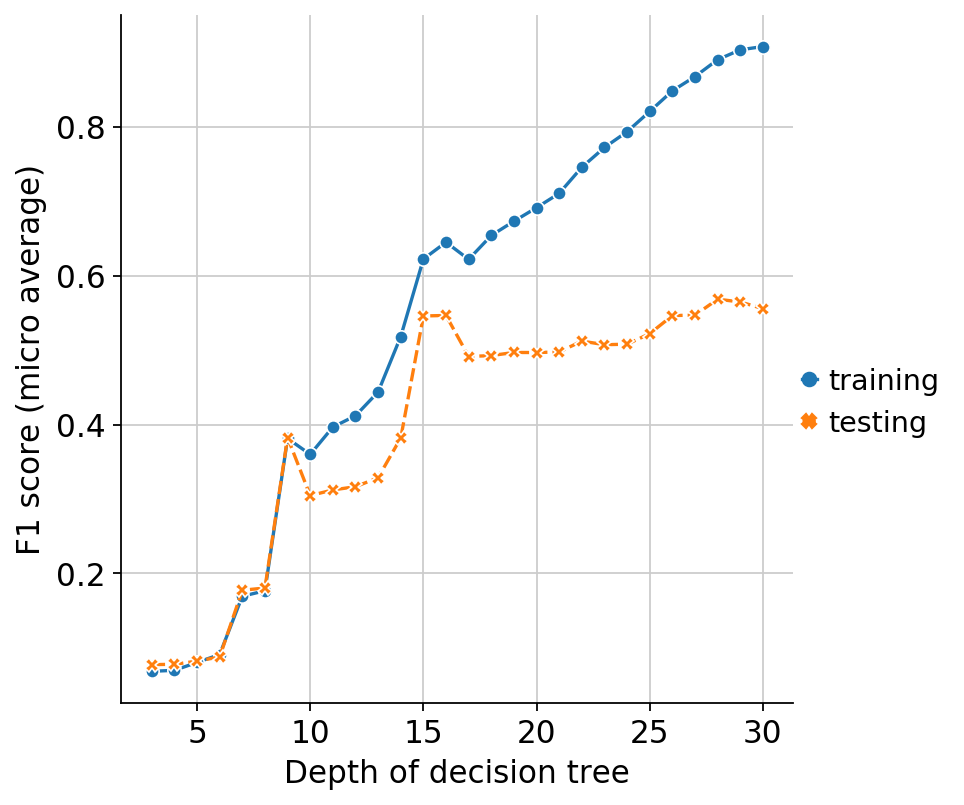

In [24]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
ax = sns.relplot(data=df, kind="line", markers=True)
ax.set(xlabel='Depth of decision tree', ylabel='F1 score (micro average)')